# Testing Different Classifiers

We will first test out a few different classification algorithms and see what performs best before we try to optimize our hyperparameters.

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None) 
import numpy as np 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample
import lightgbm as lgb 
import seaborn as sns
import matplotlib.pyplot as plt 
from imblearn.over_sampling import SMOTE


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
from google.colab import drive

drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
df = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/datasets/MLready-lc.csv', index_col='id')
df.head()

/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,loan_amnt,term,int_rate,installment,emp_length,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,acc_now_delinq,tot_coll_amt,tot_cur_bal,mths_since_rcnt_il,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,default,index,x0_A,x0_B,x0_C,x0_D,x0_E,x0_F,x0_G,x1_ANY,x1_MORTGAGE,x1_NONE,x1_OWN,x1_RENT,x2_Not Verified,x2_Source Verified,x2_Verified,x3_ANY,x3_MORTGAGE,x3_NONE,x3_OWN,x3_RENT,x4_car,x4_credit_card,x4_debt_consolidation,x4_educational,x4_home_improvement,x4_house,x4_major_purchase,x4_medical,x4_moving,x4_other,x4_renewable_energy,x4_small_business,x4_vacation,x4_wedding
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
68407277,3600.0,36,13.99,123.03,10,55000.0,5.91,0.0,675.0,679.0,1.0,30.0,-999.0,7.0,0.0,2765.0,29.7,13.0,564.0,560.0,0.0,30.0,0.0,722.0,144904.0,21.0,9300.0,4.0,20701.0,1506.0,37.2,0.0,148.0,128.0,3.0,3.0,1.0,4.0,69.0,4.0,69.0,2.0,2.0,4.0,2.0,5.0,3.0,4.0,9.0,4.0,7.0,0.0,0.0,0.0,3.0,76.9,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
68355089,24700.0,36,11.99,820.28,10,65000.0,16.06,1.0,715.0,719.0,4.0,6.0,-999.0,22.0,0.0,21470.0,19.2,38.0,699.0,695.0,0.0,-999.0,0.0,0.0,204396.0,19.0,111800.0,4.0,9733.0,57830.0,27.1,0.0,113.0,192.0,2.0,2.0,4.0,2.0,-999.0,0.0,6.0,0.0,5.0,5.0,13.0,17.0,6.0,20.0,27.0,5.0,22.0,0.0,0.0,0.0,2.0,97.4,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0,0,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
66310712,35000.0,60,14.85,829.90,10,110000.0,17.06,0.0,785.0,789.0,0.0,-999.0,-999.0,13.0,0.0,7802.0,11.6,17.0,679.0,675.0,0.0,-999.0,0.0,0.0,301500.0,23.0,67300.0,2.0,23192.0,54962.0,12.1,0.0,36.0,87.0,2.0,2.0,1.0,2.0,-999.0,-999.0,-999.0,0.0,4.0,5.0,8.0,10.0,2.0,10.0,13.0,5.0,13.0,0.0,0.0,0.0,1.0,100.0,0.0,0.0,0.0,381215.0,52226.0,62500.0,18000.0,0,2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
68476807,10400.0,60,22.45,289.91,3,104433.0,25.37,1.0,695.0,699.0,3.0,12.0,-999.0,12.0,0.0,21929.0,64.5,35.0,704.0,700.0,0.0,-999.0,0.0,0.0,331730.0,14.0,34000.0,10.0,27644.0,4567.0,77.5,0.0,128.0,210.0,4.0,4.0,6.0,4.0,12.0,1.0,12.0,0.0,4.0,6.0,5.0,9.0,10.0,7.0,19.0,6.0,12.0,0.0,0.0,0.0,4.0,96.6,60.0,0.0,0.0,439570.0,95768.0,20300.0,88097.0,0,3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
68426831,11950.0,36,13.44,405.18,4,34000.0,10.20,0.0,690.0,694.0,0.0,-999.0,-999.0,5.0,0.0,8822.0,68.4,6.0,759.0,755.0,0.0,-999.0,0.0,0.0,12798.0,338.0,12900.0,0.0,2560.0,844.0,91.0,0.0,338.0,54.0,32.0,32.0,0.0,36.0,-999.0,-999.0,-999.0,0.0,2.0,3.0,2.0,2.0,2.0,4.0,4.0,3.0,5.0,0.0,0.0,0.0,0.0,100.0,100.0,0.0,0.0,16900.0,12798.0,9400.0,4000.0,0,4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Our dataset is heavily imbalanced.

In [0]:
df['default'].value_counts(normalize=True)

0    0.857011
1    0.142989
Name: default, dtype: float64

That being the case, I am going to experiment with both upsampling and downsampling and see which works best. I really hope it's downsampling for computation's sake. 

In [0]:
# X will be every column except our target feature.
X = df.drop(columns=['default']) 
# y will be just the default column
y = df.default 
# Using train test split for this initial go round, random_state will be 7 for everything for uniformity. 
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.2, random_state=7) 

In [6]:
# Upsample using SMOTE
up = SMOTE(random_state=7, ratio = 1.0)
X_train_up, y_train_up = up.fit_sample(X_train, y_train)

# Downsample majority class
X_train_dn, y_train_dn = resample(X_train[y_train == 0],
                                y_train[y_train == 0],
                                replace=True,
                                n_samples=X_train[y_train == 1].shape[0],
                                random_state=7)
X_train_dn = np.concatenate((X_train[y_train == 1], X_train_dn))
y_train_dn = np.concatenate((y_train[y_train == 1], y_train_dn))


print("Original shape:", X_train.shape, y_train.shape)
print ("Upsampled shape:", X_train_up.shape, y_train_up.shape)
print("Downsampled shape:", X_train_dn.shape, y_train_dn.shape)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Original shape: (986707, 98) (986707,)
Upsampled shape: (1691122, 98) (1691122,)
Downsampled shape: (282292, 98) (282292,)


In [0]:
#We have to raise our max number of iterations in order for the model to run properly.
lr = LogisticRegression(max_iter=200)

#We will scale the data only for logistic regression.
sc = StandardScaler()

X_train_scl = sc.fit_transform(X_train)
X_train_up_scl = sc.fit_transform(X_train_up)
X_train_dn_scl = sc.fit_transform(X_train_dn)
 

# Create the Original, Upsampled, and Downsampled training sets
methods_data = {"Original": (X_train_scl, y_train),
                "Upsampled": (X_train_up_scl, y_train_up),
                "Downsampled": (X_train_dn_scl, y_train_dn)}

# Loop through each type of training sets and apply 5-Fold CV using Logistic Regression
for method in methods_data.keys():
    lr_results = cross_val_score(LogisticRegression(max_iter=200), methods_data[method][0], methods_data[method][1], cv=5, scoring='f1')
    print(f"The best F1 Score for {method} data:")
    print (lr_results.mean())

The best F1 Score for Original data:
0.7292446846621529
The best F1 Score for Upsampled data:
0.9205614688957491
The best F1 Score for Downsampled data:
0.906340658903072


The winner is... upsampling. Boo. Let's see how how our model does with the test data. 

In [0]:
lr = LogisticRegression(max_iter=200)
lr.fit(X_train_up_scl, y_train_up)
print ("\n\n ---Logistic Regression Model---")
lr_roc_auc = roc_auc_score(y_test, lr.predict(X_test))
print ("Logistic Regression AUC = %2.2f" % lr_roc_auc)
print(classification_report(y_test, lr.predict(X_test)))




 ---Logistic Regression Model---
Logistic Regression AUC = 0.50
              precision    recall  f1-score   support

           0       0.86      1.00      0.92    211463
           1       0.08      0.00      0.00     35214

    accuracy                           0.86    246677
   macro avg       0.47      0.50      0.46    246677
weighted avg       0.75      0.86      0.79    246677



This is a terrible model. Having this many features makes it difficult for a Logistic Regression to do well. Let's hope the other algorithms have a better time.

# Random Forest 

Random Forest should perform better. We will continue to use the upsampled data along with the regular data to see what performs better.

In [0]:
#Upsampled Data
rf = RandomForestClassifier(n_estimators=100)

rf_results = cross_val_score(rf, X_train_up, y_train_up, cv=5, scoring='f1')

print(f'The scores of our Random Forest cross validation were {rf_results}')
print(f'The mean of our Random Forest cross validation is {rf_results.mean()}')

The scores of our Random Forest cross validation were [0.33025667 0.9721977  0.97205628 0.97190507 0.97228764]
The mean of our Random Forest cross validation is 0.8437406739537089


In [12]:
#Regular Data
rf = RandomForestClassifier(n_estimators=100)

rf_results = cross_val_score(rf, X_train, y_train, cv=5, scoring='f1')

print(f'The scores of our Random Forest cross validation were {rf_results}')
print(f'The mean of our Random Forest cross validation is {rf_results.mean()}')

The scores of our Random Forest cross validation were [0.74128558 0.73748325 0.74104517 0.74312968 0.7398061 ]
The mean of our Random Forest cross validation is 0.7405499565454228


And now we will try out the testing data. Once again we will train with both upsampled and normal data. 

In [0]:
#Upsampled
rf = RandomForestClassifier(n_estimators=100)
rf = rf.fit(X_train_up, y_train_up)

print ("\n\n ---Random Forest Model---")
rf_roc_auc = roc_auc_score(y_test, rf.predict(X_test))
print ("Random Forest AUC = %2.2f" % rf_roc_auc)
print(classification_report(y_test, rf.predict(X_test)))



 ---Random Forest Model---
Random Forest AUC = 0.86
              precision    recall  f1-score   support

           0       0.96      0.95      0.96    211463
           1       0.72      0.77      0.75     35214

    accuracy                           0.92    246677
   macro avg       0.84      0.86      0.85    246677
weighted avg       0.93      0.92      0.93    246677



In [13]:
#Normal
rf = RandomForestClassifier(n_estimators=100)
rf = rf.fit(X_train, y_train)

print ("\n\n ---Random Forest Model---")
rf_roc_auc = roc_auc_score(y_test, rf.predict(X_test))
print ("Random Forest AUC = %2.2f" % rf_roc_auc)
print(classification_report(y_test, rf.predict(X_test)))



 ---Random Forest Model---
Random Forest AUC = 0.85
              precision    recall  f1-score   support

           0       0.96      0.96      0.96    211463
           1       0.74      0.74      0.74     35214

    accuracy                           0.93    246677
   macro avg       0.85      0.85      0.85    246677
weighted avg       0.93      0.93      0.93    246677



# Gradient Boosting

We will repeat the exact same steps with Gradient Boosting. 

In [0]:
#Upsampled
gb = lgb.LGBMClassifier()

gb_results = cross_val_score(gb, X_train_up, y_train_up, cv=5, scoring='f1')

print(f'The scores of our Gradient Boosting cross validation were {gb_results}')
print(f'The mean of our Gradient Boosting cross validation is {gb_results.mean()}')

The scores of our Gradient Boosting cross validation were [0.28376287 0.97492557 0.97439638 0.97476398 0.97481668]
The mean of our Gradient Boosting cross validation is 0.8365330968023384


In [10]:
#Normal
gb = lgb.LGBMClassifier()

gb_results = cross_val_score(gb, X_train, y_train, cv=5, scoring='f1')

print(f'The scores of our Gradient Boosting cross validation were {gb_results}')
print(f'The mean of our Gradient Boosting cross validation is {gb_results.mean()}')

The scores of our Gradient Boosting cross validation were [0.74892568 0.74809997 0.74877263 0.75173346 0.74817737]
The mean of our Gradient Boosting cross validation is 0.7491418214630101


In [0]:
#Upsampled
gb = lgb.LGBMClassifier()
gb = gb.fit(X_train_up, y_train_up)

print ("\n\n ---Gradient Boosting Model---")
gb_roc_auc = roc_auc_score(y_test, gb.predict(X_test))
print ("Gradient Boosting AUC = %2.2f" % gb_roc_auc)
print(classification_report(y_test, gb.predict(X_test)))




 ---Gradient Boosting Model---
Gradient Boosting AUC = 0.85
              precision    recall  f1-score   support

           0       0.96      0.96      0.96    211463
           1       0.74      0.75      0.75     35214

    accuracy                           0.93    246677
   macro avg       0.85      0.85      0.85    246677
weighted avg       0.93      0.93      0.93    246677



In [11]:
#Normal
gb = lgb.LGBMClassifier()
gb = gb.fit(X_train, y_train)

print ("\n\n ---Gradient Boosting Model---")
gb_roc_auc = roc_auc_score(y_test, gb.predict(X_test))
print ("Gradient Boosting AUC = %2.2f" % gb_roc_auc)
print(classification_report(y_test, gb.predict(X_test)))



 ---Gradient Boosting Model---
Gradient Boosting AUC = 0.85
              precision    recall  f1-score   support

           0       0.96      0.96      0.96    211463
           1       0.74      0.75      0.75     35214

    accuracy                           0.93    246677
   macro avg       0.85      0.85      0.85    246677
weighted avg       0.93      0.93      0.93    246677



# Comparing The Classifiers

It's fascinating that using upsampled data has a profound effect on cross-validation but does not do much to our f1 scores. I will stick with just our normal data as it is quicker than upsampling. 

Let's look at the ROC curves of our models. 

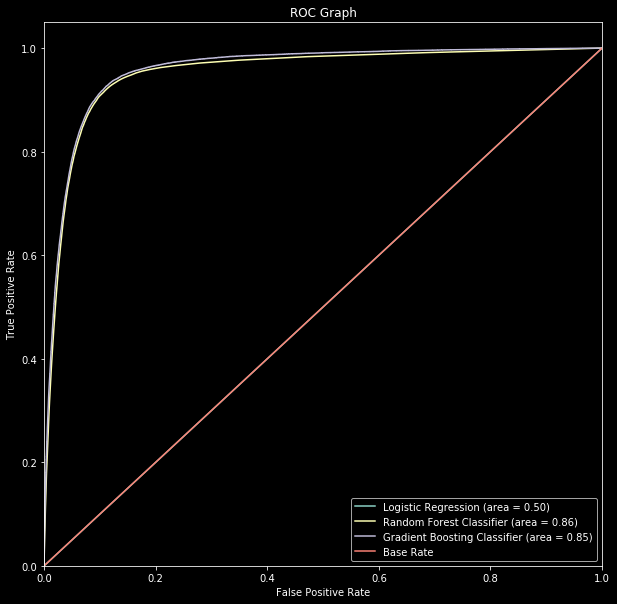

In [0]:
# Create ROC Graph
plt.style.use('dark_background')
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, lr.predict_proba(X_test)[:,1])
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test, rf.predict_proba(X_test)[:,1])
gb_fpr, gb_tpr, gb_thresholds = roc_curve(y_test, gb.predict_proba(X_test)[:,1])


plt.figure(figsize=(10,10))

# Plot Logistic Regression ROC
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % lr_roc_auc)

# Plot Random Forest ROC
plt.plot(rf_fpr, rf_tpr, label='Random Forest Classifier (area = %0.2f)' % rf_roc_auc)

# Plot Gradient Boost ROC
plt.plot(gb_fpr, gb_tpr, label='Gradient Boosting Classifier (area = %0.2f)' % gb_roc_auc)

# Plot Base Rate ROC
plt.plot([0,1], [0,1],label='Base Rate')


plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Graph')
plt.legend(loc="lower right")
plt.show()

Random Forest is ever so slightly better than Gradient Boosting. Logistic Regression is literally the same as flipping the coin. How do Gradient Boosting and Random Forest rate their features?

# Random Forest Feature Importances

In [27]:
feature_importances1 = pd.DataFrame(rf.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
feature_importances1 = feature_importances1.reset_index()
feature_importances1.head(20)

,index,importance
0,last_fico_range_high,0.280181
1,last_fico_range_low,0.233651
2,int_rate,0.018642
3,installment,0.014920
4,dti,0.013809
5,index,0.013797
6,loan_amnt,0.013132
7,mo_sin_old_rev_tl_op,0.012640
8,bc_open_to_buy,0.011691
9,total_rev_hi_lim,0.011630


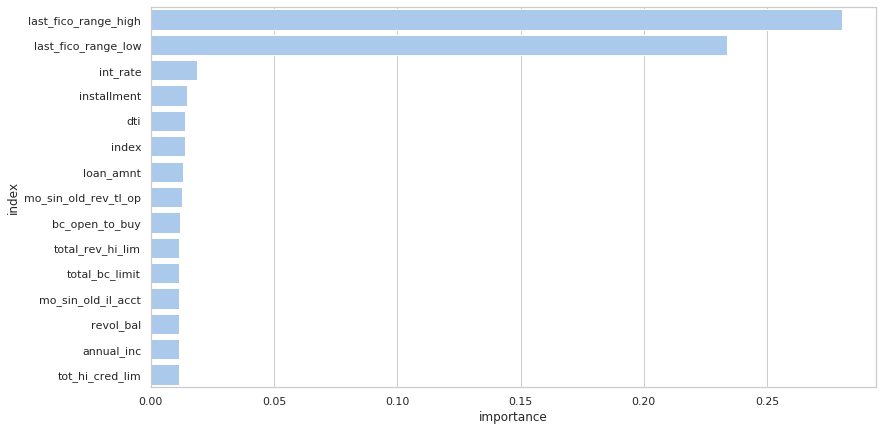

In [28]:
sns.set(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(13, 7))

# Plot the Feature Importance
sns.set_color_codes("pastel")
sns.barplot(x="importance", y='index', data=feature_importances1.head(15),
            label="Total", color="b")
plt.show()

# Gradient Boosting Feature Importances

In [33]:
feature_importances2 = pd.DataFrame(gb.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
feature_importances2 = feature_importances2.reset_index()
feature_importances2.head(20)

,index,importance
0,last_fico_range_high,494
1,index,247
2,loan_amnt,158
3,mo_sin_old_rev_tl_op,148
4,total_acc,123
5,annual_inc,118
6,int_rate,112
7,dti,107
8,installment,104
9,num_rev_tl_bal_gt_0,89


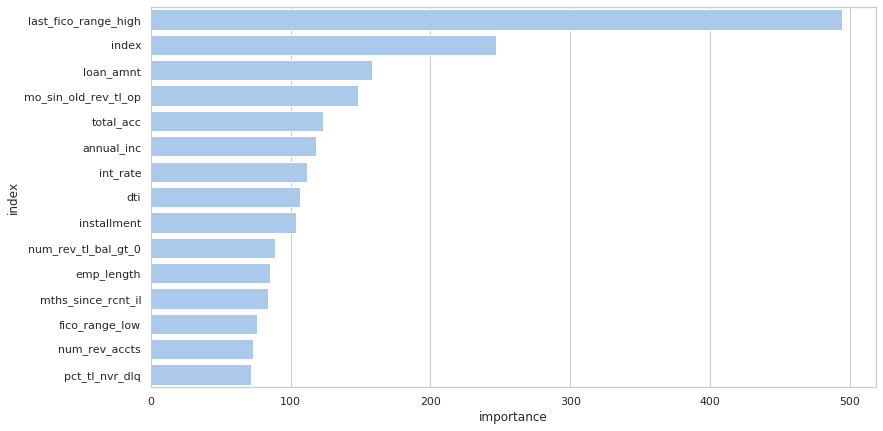

In [30]:
sns.set(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(13, 7))

# Plot the Feature Importance
sns.set_color_codes("pastel")
sns.barplot(x="importance", y='index', data=feature_importances2.head(15),
            label="Total", color="b")
plt.show()

# Comparing Feature Importances

Random Forest puts a ton of weight on the most recent FICO scores. Gradient boosting still sees them as important but gives a lot more weight to other features as well. In spite of this, their results are very close to one another. 